In [1]:
import numpy as np
import numpy.testing as npt
from numpy.random import poisson, randint, random
from numpy.linalg import norm
from scipy.sparse import csr_matrix
from sbpr import (fast_bootstrap, update_user_matrix, update_item_matrix,
                  simulate, user_item_ranks, _calc_ranks,
                  cost, rank, sigmoid, auc, predict, f1_score, predict_top_ranks
                 )
import copy
from bayes_opt import BayesianOptimization

from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

/Users/mortonjt/miniconda3/envs/cse258/lib/python3.6/site-packages/numba/decorators.py:149: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


Load up the data.

In [2]:
prior_products = pd.read_csv('order_products__prior.csv')
train_products = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
prior_orders = orders.loc[orders.eval_set=='prior']
train_orders = orders.loc[orders.eval_set=='train']
user_orders = prior_orders.user_id.value_counts()
product_orders = prior_products.product_id.value_counts()

Perform some preprocessing.  Here we will remove users and items with less than 20 counts.

In [3]:
## removing users
user_set = set(user_orders.loc[user_orders > 50].index)
prior_orders = prior_orders.loc[
    [i in user_set for i in prior_orders.user_id]
]
train_orders = train_orders.loc[
    [i in user_set for i in train_orders.user_id]
]

## removing items
product_set = set(product_orders.loc[product_orders > 1000].index)
prior_products = prior_products.loc[
    [i in product_set for i in prior_products.product_id]
]
train_products = train_products.loc[
    [i in product_set for i in train_products.product_id]
]

We'll merge together the users along with their orders and products

In [6]:
A = prior_orders[['user_id', 'order_id', 'order_number']].sort_values('order_id')
B = prior_products[['order_id', 'product_id']].sort_values('order_id')    
C = pd.merge(A, B, on='order_id')
prior = C.sort_values(by=['user_id', 'order_number']) # account for 1 offset

A = train_orders[['user_id', 'order_id', 'order_number']].sort_values('order_id')
B = train_products[['order_id', 'product_id']].sort_values('order_id')    
C = pd.merge(A, B, on='order_id')
train = C.sort_values(by=['user_id', 'order_number']) # account for 1 offset

We will need to relabel all of the user_ids, order_numbers, and product_numbers
to make sure that they are all based on 0-based indexing.

In [7]:
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_product = preprocessing.LabelEncoder()

le_product.fit(prior.product_id)
le_user.fit(prior.user_id)

LabelEncoder()

In [8]:
prior['user_id'] = le_user.transform(prior['user_id'])
train['user_id'] = le_user.transform(train['user_id'])

prior['product_id'] = le_product.transform(prior['product_id'])
train['product_id'] = le_product.transform(train['product_id'])

We'll create an extra dataset to perform validation with.

In [9]:
from numba import jit
@jit(nopython=True, cache=True)
def stupid_query(X, sizes):
    idx = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        u = X[i, 0]
        o = X[i, 2]
        idx[i] = (o == (sizes[u] - 1))
    return idx

In [10]:
sizes = prior.groupby(['user_id', 'order_id']).size()
user_orders = [len(sizes[i]) for i in range(len(np.unique(prior.user_id)))]
idx = stupid_query(prior.values, np.array(user_orders))
idx = idx.astype(np.bool)

prior_train = prior.iloc[~idx]
prior_test = prior.iloc[idx]

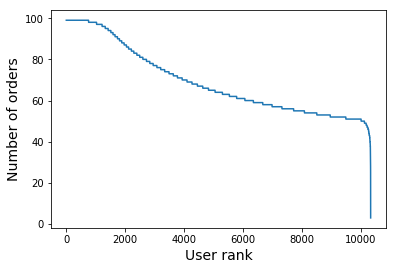

In [256]:
plt.plot(np.sort(user_orders)[::-1])
plt.xlabel('User rank', fontsize=14)
plt.ylabel('Number of orders', fontsize=14)
plt.savefig('figures/order_sizes.png')

In [11]:
len(prior.product_id.unique())

5053

In [12]:
len(prior_train.product_id.unique())

5053

In [13]:
len(np.unique(prior_test.user_id))

10203

In [14]:
len(np.unique(prior_train.user_id))

10327

In [16]:
len(np.unique(prior.user_id))

10327

In [17]:
len(np.unique(train.user_id))

6491

In [257]:
len(prior)

5953102

In [258]:
len(prior_train)

5860495

In [259]:
len(prior_test)

92607

In [260]:
len(train)

59928

Let's build some models.

In [215]:
num_boots = 10000
num_iters = 300

kU = len(prior_train.user_id.unique())
kI = len(prior_train.product_id.unique())
kL = kI
#params = {'clip': 10.0, 'rUI': 1.0, 'lam_iu': 0.0, 'decay': 1.0, 'alpha': 9.9999999999999995e-07, 'rIL': 1.0, 'lam_il': 100.0, 'lam_li': 0.0, 'lam_ui': 100.0}
#params = {'alpha': 1.0,'clip': 10.0, 'decay': 0.69999999999999996, 'lam_il': 10.0, 'lam_iu': 0.0, 'lam_li': 0.0, 'lam_ui': 10.0, 'rIL': 1.0, 'rUI': 1.0}
params = {'decay': 0.69999999999999996, 'lam_il': 100.0, 'lam_ui': 0.0, 'rUI': 1.0, 'clip': 10.0, 'alpha': 1.0, 'rIL': 100.0, 'lam_iu': 0.0, 'lam_li': 100.0}
clip = params['clip']
rIL = params['rIL']
alpha = params['alpha']
lam_il = params['lam_il']
lam_ui = params['lam_ui']
lam_iu = params['lam_iu']
decay = params['decay']
rUI = params['rUI']
lam_li = params['lam_li']

verbose = True

rUI = int(rUI)
rIL = int(rIL)
V_ui = np.random.normal(size=(kU, rUI))
V_iu = np.random.normal(size=(kI, rUI))
V_li = np.random.normal(size=(kI, rIL))
V_il = np.random.normal(size=(kI, rIL))

I = list(range(kI))

for b in range(num_iters):
    gen = list(fast_bootstrap(prior_train.values, I, num_boots))

    dV_ui = np.zeros(shape=(kU, rUI))
    dV_iu = np.zeros(shape=(kI, rUI))
    dV_li = np.zeros(shape=(kI, rIL))
    dV_il = np.zeros(shape=(kI, rIL))

    for boot in gen:
        update_user_matrix(boot, dV_ui, dV_iu,
                           V_ui, V_iu, V_li, V_il,
                           alpha=alpha, lam_ui=lam_ui, lam_iu=lam_iu)

        update_item_matrix(boot, dV_li, dV_il,
                           V_ui, V_iu, V_li, V_il,
                           alpha=alpha, lam_il=lam_il, lam_li=lam_li)

    # gradient clipping:
    # http://www.wildml.com/deep-learning-glossary/#gradient-clipping
    V_ui += (dV_ui * clip) / norm(dV_ui)
    V_iu += (dV_iu * clip) / norm(dV_iu)
    V_li += (dV_li * clip) / norm(dV_li)
    V_il += (dV_il * clip) / norm(dV_il)
    c = 0 # cost
    cs = []
    for boot in gen:
        c = cost(boot,
                 V_ui, V_iu, V_li, V_il,
                 lam_ui=0, lam_iu=0,
                 lam_il=0, lam_li=0)
        cs.append(c)
    if np.mean(cs) > -0.1: break
    alpha *= decay
    if b % 50 == 0 and verbose:
        print('cost %3.3f' % np.mean(cs),
              'V_ui [%3.3f, %3.3f]'   % (V_ui.min(), V_ui.max()),
              'V_iu [%3.3f, %3.3f]'   % (V_iu.min(), V_iu.max()),
              'V_li [%3.3f, %3.3f]'   % (V_li.min(), V_li.max()),
              'V_il [%3.3f, %3.3f]'   % (V_il.min(), V_il.max()))

cost -1.846 V_ui [-3.762, 3.676] V_iu [-4.423, 3.501] V_li [-4.524, 4.853] V_il [-4.603, 4.670]
cost -0.359 V_ui [-3.203, 2.632] V_iu [-5.343, 2.777] V_li [-3.882, 3.813] V_il [-2.272, 2.573]
cost -0.312 V_ui [-4.349, 1.743] V_iu [-11.723, 2.665] V_li [-3.559, 3.575] V_il [-1.503, 1.140]
cost -0.320 V_ui [-3.887, 1.768] V_iu [-12.915, 2.892] V_li [-3.245, 3.365] V_il [-1.577, 1.196]
cost -0.306 V_ui [-3.668, 1.305] V_iu [-12.551, 3.016] V_li [-3.139, 3.152] V_il [-1.576, 1.195]
cost -0.320 V_ui [-3.669, 1.283] V_iu [-13.040, 3.277] V_li [-2.988, 2.957] V_il [-1.576, 1.195]


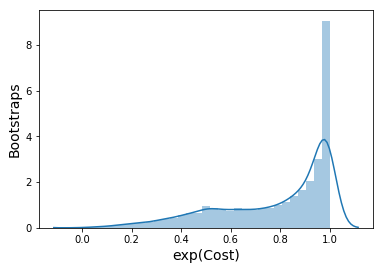

In [254]:
sns.distplot(np.exp(cs))
plt.xlabel('exp(Cost)', fontsize=14)
plt.ylabel('Bootstraps', fontsize=14)
plt.savefig('figures/cost.png')

In [217]:
np.mean(np.exp(cs))

0.78330826783342544

In [245]:
Us = prior_test.user_id.value_counts().sort_index()
Us = np.array([
    Us[i] if i in Us.index else 0
    for i in range(len(np.unique(prior.user_id)))
])

est = predict(V_ui, V_iu, V_il, V_li, prior_test.values, Us, I, N=10, subsize=None)
est = est.astype(np.int)

In [246]:
f1, prec, rec = f1_score(est.astype(np.int), prior_test.values)

In [247]:
f1

0.044767813868402742

In [248]:
prec, rec = np.array(prec), np.array(rec)

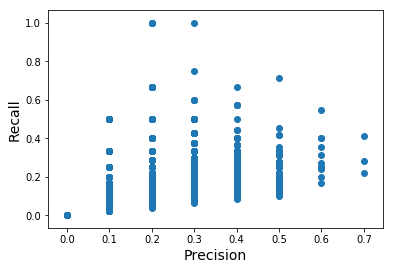

In [255]:
plt.scatter(prec, rec)
plt.xlabel('Precision', fontsize=14)
plt.ylabel('Recall', fontsize=14)
plt.savefig('figures/precision_recall.png')